In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.extend(["/home/nick/C2S-Python-API/"])

import shapely
from tqdm import tqdm
import geopandas as gpd
import datetime as dt
import numpy as np
import pandas as pd  # Needs a newer version than 1.3.4, update with !pip install -U pandas
import dataretrieval.nwis as nwis # If missing install with !pip install dataretrieval
import matplotlib.pyplot as plt
import geojson
from rio_cogeo.profiles import cog_profiles
from rasterio.warp import Resampling
from pyproj import Transformer, Proj
plt.rcParams.update({'font.size': 16})
plt.style.use('ggplot')

from c2s.credentials import get_gcsfs

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import rasterio
import rasterio.transform
import rasterio.features
import rasterio.warp

import scipy.interpolate

In [4]:
os.environ["WBT_LINUX"] = "MUSL"

In [50]:
fs = get_gcsfs()

## Check how many stream gauges are within the Montpelier AOI

In [3]:
path_aoi = "gs://insurance_demos/SwissRe/Vermont/aois/Montpelier_box.geojson"

with fs.open(path_aoi, 'r') as f:
    df_geo = gpd.read_file(f)
print(f"{df_geo.shape[0]} AOIs")

1 AOIs


In [8]:
bbox = list(df_geo.geometry.iloc[0].bounds)
print(bbox)

[-72.64052468376205, 44.21735072930057, -72.50758082720895, 44.296052823068024]


In [18]:
daily_or_subdaily_values = "dv" 
discharge_or_height = "00065" # "00060": discharge, "00065": height

df_nwis, meta_nwis = nwis.what_sites(
    bBox=np.round(bbox, 6).tolist(), # truncate to avoid 400 error!
    outputDataTypeCd=daily_or_subdaily_values,
    parameterCd=discharge_or_height # discharge parameter
    )
df_nwis["years_of_history"] = df_nwis[['begin_date', 'end_date']].apply(lambda x: (pd.to_datetime(x['end_date']) - pd.to_datetime(x['begin_date'])).days / 365, axis=1)

print(f"Found {len(df_nwis):4} stream gauges. {df_nwis[df_nwis['years_of_history'] > 10].shape[0]:4} > 10 year history, "
      f"{df_nwis[df_nwis['years_of_history'] > 20].shape[0]:4} > 20 year history")

Found    3 stream gauges.    0 > 10 year history,    0 > 20 year history


In [10]:
df_nwis

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,...,ts_id,loc_web_ds,medium_grp_cd,parm_grp_cd,srs_id,access_cd,begin_date,end_date,count_nu,years_of_history
0,USGS,04286000,"WINOOSKI RIVER AT MONTPELIER, VT",ST,44.256726,-72.593443,S,NAD83,499.87,0.16,...,65074,NaN,wat,NaN,1645423,0,1914-07-01,2023-08-14,38084,109.194521
1,USGS,04287300,"SUNNY BROOK NEAR MONTPELIER, VT",ST,44.268114,-72.624000,S,NAD83,510.00,20.00,...,65077,NaN,wat,NaN,1645423,0,1963-10-01,1974-09-30,4018,11.005479


In [11]:
df_nwis.columns

Index(['agency_cd', 'site_no', 'station_nm', 'site_tp_cd', 'dec_lat_va',
       'dec_long_va', 'coord_acy_cd', 'dec_coord_datum_cd', 'alt_va',
       'alt_acy_va', 'alt_datum_cd', 'huc_cd', 'data_type_cd', 'parm_cd',
       'stat_cd', 'ts_id', 'loc_web_ds', 'medium_grp_cd', 'parm_grp_cd',
       'srs_id', 'access_cd', 'begin_date', 'end_date', 'count_nu',
       'years_of_history'],
      dtype='object')

In [ ]:
# montpelier aoi
(10450.331 * 8586.598 * 10499.602 *8586.913) / (1000 * 1000)

## Check how many gauges are in the Davenport AOI

In [20]:
# davenport aoi area
(35766.632 * 26196.646 * 35895.353 * 26039.307) / (1000 * 1000)

875772670194.6465

In [35]:
aoi = {
    "geometry": {
        "coordinates": [
            [
                [
                    -90.75120643574343,
                    41.63442565044011
                ],
                [
                    -90.75120643574343,
                    41.40000661171891
                ],
                [
                    -90.32305627367782,
                    41.40000661171891
                ],
                [
                    -90.32305627367782,
                    41.63442565044011
                ],
                [
                    -90.75120643574343,
                    41.63442565044011
                ]
            ]
        ],
    }
}

In [43]:
gdf = gpd.GeoDataFrame({"geometry": [shapely.geometry.shape(aoi["geometry"])]})
gdf

,geometry
0,"POLYGON ((-90.75121 41.63443, -90.75121 41.400..."


In [45]:
bbox = list(gdf.geometry.iloc[0].bounds)
print(bbox)

[-90.75120643574343, 41.40000661171891, -90.32305627367782, 41.63442565044011]


In [47]:
daily_or_subdaily_values = "dv" 
discharge_or_height = "00060" # "00060": discharge, "00065": height

df_nwis, meta_nwis = nwis.what_sites(
    bBox=np.round(bbox, 6).tolist(), # truncate to avoid 400 error!
    outputDataTypeCd=daily_or_subdaily_values,
    parameterCd=discharge_or_height # discharge parameter
    )
df_nwis["years_of_history"] = df_nwis[['begin_date', 'end_date']].apply(lambda x: (pd.to_datetime(x['end_date']) - pd.to_datetime(x['begin_date'])).days / 365, axis=1)

print(f"Found {len(df_nwis):4} stream gauges. {df_nwis[df_nwis['years_of_history'] > 10].shape[0]:4} > 10 year history, "
      f"{df_nwis[df_nwis['years_of_history'] > 20].shape[0]:4} > 20 year history")

Found   18 stream gauges.    6 > 10 year history,    5 > 20 year history


In [49]:
df_nwis.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,...,ts_id,loc_web_ds,medium_grp_cd,parm_grp_cd,srs_id,access_cd,begin_date,end_date,count_nu,years_of_history
0,USGS,05422450,"Crow Creek at Mount Joy, IA",ST,41.615032,-90.549303,F,NAD83,695.57,0.5,...,42815,NaN,wat,NaN,1645423,0,1977-09-24,1982-09-30,1833,5.019178
1,USGS,05422470,"Crow Creek at Bettendorf, IA",ST,41.551144,-90.455131,F,NAD83,576.68,0.1,...,325231,sediment station,wat,NaN,1645597,0,1978-03-21,1981-12-31,1373,3.783562
2,USGS,05422470,"Crow Creek at Bettendorf, IA",ST,41.551144,-90.455131,F,NAD83,576.68,0.1,...,42817,NaN,wat,NaN,1645423,0,1977-10-01,2008-09-30,11323,31.019178
3,USGS,05422470,"Crow Creek at Bettendorf, IA",ST,41.551144,-90.455131,F,NAD83,576.68,0.1,...,42822,NaN,wat,NaN,17164583,0,2008-10-01,2023-08-14,5238,14.876712
4,USGS,05422470,"Crow Creek at Bettendorf, IA",ST,41.551144,-90.455131,F,NAD83,576.68,0.1,...,42818,sediment station,wat,NaN,1646694,0,1978-03-21,1981-09-29,1283,3.528767


In [55]:
meta_nwis.variable_info()[0]

,parameter_cd,group,parm_nm,epa_equivalence,result_statistical_basis,result_time_basis,result_weight_basis,result_particle_size_basis,result_sample_fraction,result_temperature_basis,CASRN,SRSName,parm_unit
0,00060,Physical,"Discharge, cubic feet per second",Not checked,Mean,1 Day,NaN,NaN,NaN,NaN,,"Stream flow, mean. daily",ft3/s


## Spatial distribution of gauges in given AOIs

### In the training geoms

In [82]:
training_gdf = gpd.read_file("20230517_v2_v58_heldout_validation_set_geogroup_metrics.geojson")
training_gdf

,rmse_largediff_fbnf,rmse_notn_fbnf,geometry
0,0.338063,0.169971,"POLYGON ((-96.29352 35.15412, -96.29175 35.110..."
1,0.344088,0.190079,"POLYGON ((-95.53073 36.74856, -95.54179 36.501..."
2,0.313088,0.158269,"POLYGON ((-96.46234 38.95697, -96.47444 39.203..."
3,0.405276,0.260264,"POLYGON ((-94.79425 32.43644, -94.79492 32.436..."
4,0.410291,0.233432,"POLYGON ((-95.06352 29.12376, -95.06988 29.101..."
...,...,...,...
1451,0.293872,0.137460,"POLYGON ((-79.79480 35.14890, -81.00022 35.154..."
1452,0.287957,0.134803,"POLYGON ((-79.79480 35.14890, -80.13920 35.150..."
1453,0.317225,0.166577,"POLYGON ((-77.19754 35.22313, -77.19521 35.134..."
1454,0.308089,0.152698,"MULTIPOLYGON (((-85.95792 29.73816, -85.96591 ..."


In [51]:
# load the locations of all US stream gauges
with fs.open("gs://streamgauge_data/all_stream_gauges_dv_2023_08_10.geojson", 'r') as f:
    dv_gauges = gpd.read_file(f)

In [52]:
dv_gauges.loc[:, "geometry"] = dv_gauges.apply(lambda x: shapely.geometry.Point(x["dec_long_va"], x["dec_lat_va"]), axis=1)

/tmp/ipykernel_685510/2591277715.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dv_gauges.loc[:, "geometry"] = dv_gauges.apply(lambda x: shapely.geometry.Point(x["dec_long_va"], x["dec_lat_va"]), axis=1)


In [53]:
# number of stream gauge points in the first geometry
test_geom = training_gdf.iloc[0]["geometry"]
np.sum(dv_gauges.within(test_geom))

22

In [96]:
# for each training geometry, check how many stream gauges it contains
contained = []
for geom in tqdm(training_gdf["geometry"].tolist()):
    contained.append(np.sum(dv_gauges.within(geom)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1456/1456 [03:12<00:00,  7.58it/s]


In [97]:
training_gdf.loc[:, "num_gauges"] = contained

mean: 55.11538461538461
min:  0
max:  434


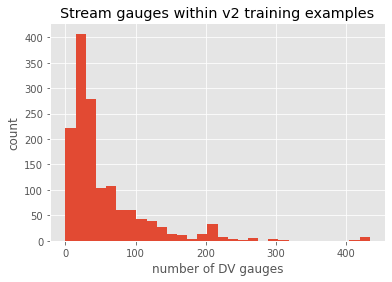

In [101]:
plt.hist(contained, bins=30)
plt.xlabel("number of DV gauges")
plt.ylabel("count")
plt.title("Stream gauges within v2 training examples")
print("mean:", np.array(contained).mean())
print("min: ", np.array(contained).min())
print("max: ", np.array(contained).max())

In [111]:
# number of examples with no stream gauges?
np.sum(training_gdf["num_gauges"] == 0)

6

In [191]:
#length of each ID?
np.sum(dv_gauges["site_no"].apply(len) == 15)

1348

In [193]:
#length of each ID?
set((dv_gauges["site_no"].apply(len)).tolist())

{8, 9, 10, 11, 12, 13, 14, 15}

### In the proposed Gridded V2 grid cells

In [103]:
with fs.open("gs://daily_flood_v2_gridded_data/grid/v2_grid_100km.fgb", "rb") as f:
    gridcell_gdf = gpd.read_file(f)

In [104]:
gridcell_gdf

,index,left,top,bottom,right,hXX,vYY,hXXvYY,geometry
0,1832,2.296501e+06,-1.880500e+06,-1.980500e+06,2.396501e+06,46,38,h46v38,"POLYGON ((2396500.823 -1980500.337, 2396500.82..."
1,1831,2.296501e+06,-1.780500e+06,-1.880500e+06,2.396501e+06,46,37,h46v37,"POLYGON ((2396500.823 -1880500.337, 2396500.82..."
2,1792,2.196501e+06,-1.780500e+06,-1.880500e+06,2.296501e+06,45,37,h45v37,"POLYGON ((2296500.823 -1880500.337, 2296500.82..."
3,1753,2.096501e+06,-1.780500e+06,-1.880500e+06,2.196501e+06,44,37,h44v37,"POLYGON ((2196500.823 -1880500.337, 2196500.82..."
4,1793,2.196501e+06,-1.880500e+06,-1.980500e+06,2.296501e+06,45,38,h45v38,"POLYGON ((2296500.823 -1980500.337, 2296500.82..."
...,...,...,...,...,...,...,...,...,...
1828,77,-2.203499e+06,-1.880500e+06,-1.980500e+06,-2.103499e+06,1,38,h01v38,"POLYGON ((-2103499.177 -1980500.337, -2103499...."
1829,115,-2.103499e+06,-1.780500e+06,-1.880500e+06,-2.003499e+06,2,37,h02v37,"POLYGON ((-2003499.177 -1880500.337, -2003499...."
1830,76,-2.203499e+06,-1.780500e+06,-1.880500e+06,-2.103499e+06,1,37,h01v37,"POLYGON ((-2103499.177 -1880500.337, -2103499...."
1831,37,-2.303499e+06,-1.780500e+06,-1.880500e+06,-2.203499e+06,0,37,h00v37,"POLYGON ((-2203499.177 -1880500.337, -2203499...."


In [107]:
# reproject streamgauges into CRS of the grid cells
dv_gauges_reproj = dv_gauges.to_crs(crs=gridcell_gdf.crs)

In [108]:
# for each training geometry, check how many stream gauges it contains
contained = []
for geom in tqdm(gridcell_gdf["geometry"].tolist()):
    contained.append(np.sum(dv_gauges_reproj.within(geom)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1833/1833 [04:06<00:00,  7.43it/s]


In [109]:
gridcell_gdf.loc[:, "num_gauges"] = contained

In [120]:
# remove grid cells outside of CONUS
borders = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = borders.loc[borders["name"] == "United States of America", :].to_crs(gridcell_gdf.crs)
gridcell_gdf = gridcell_gdf.loc[gridcell_gdf.within(usa.iloc[0]["geometry"]), :]

mean: 43.83584337349398
min:  0
max:  363


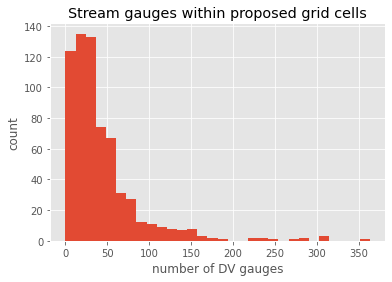

In [122]:
plt.hist(gridcell_gdf["num_gauges"], bins=30)
plt.xlabel("number of DV gauges")
plt.ylabel("count")
plt.title("Stream gauges within proposed grid cells")
print("mean:", np.array(gridcell_gdf["num_gauges"]).mean())
print("min: ", np.array(gridcell_gdf["num_gauges"]).min())
print("max: ", np.array(gridcell_gdf["num_gauges"]).max())

In [123]:
np.sum(gridcell_gdf["num_gauges"]==0)

8

## Checking out the statistics service

In [65]:
# by default, this returns the daily statistics, i.e. what is the average streamflow value for January 1st over the available record
# note that these are computed over WATER YEARS, not CALENDAR YEARS. Water years start on October 1st of the year before the calendar year.
daily_stats = nwis.get_record(sites='03339000', service='stat', start='2017-12-31', parameterCd='00065')
daily_stats

,agency_cd,site_no,parameter_cd,ts_id,loc_web_ds,month_nu,day_nu,begin_yr,end_yr,count_nu,...,mean_va,p05_va,p10_va,p20_va,p25_va,p50_va,p75_va,p80_va,p90_va,p95_va
0,USGS,03339000,00065,48112,NaN,1,1,1994,2023,28,...,5.40,2.39,2.73,3.12,3.43,4.39,6.09,7.20,10.82,14.67
1,USGS,03339000,00065,48112,NaN,1,2,1994,2023,27,...,4.94,2.36,2.69,2.94,3.13,4.06,6.22,6.60,9.30,12.65
2,USGS,03339000,00065,48112,NaN,1,3,1994,2023,28,...,4.65,2.53,2.71,3.07,3.18,4.21,5.59,6.17,7.62,9.92
3,USGS,03339000,00065,48112,NaN,1,4,1994,2023,28,...,4.91,2.55,2.74,3.10,3.12,4.37,5.92,6.37,8.42,10.36
4,USGS,03339000,00065,48112,NaN,1,5,1994,2023,28,...,5.15,2.56,2.75,3.06,3.21,4.51,5.83,6.18,8.97,14.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,USGS,03339000,00065,48112,NaN,12,27,1994,2023,26,...,5.03,2.32,2.68,2.81,2.86,4.16,5.13,6.08,10.19,16.09
362,USGS,03339000,00065,48112,NaN,12,28,1994,2023,26,...,5.35,2.29,2.66,2.76,2.94,4.21,5.52,6.05,10.71,20.24
363,USGS,03339000,00065,48112,NaN,12,29,1994,2023,26,...,5.60,2.32,2.59,2.73,2.79,3.89,6.00,6.60,12.01,23.13
364,USGS,03339000,00065,48112,NaN,12,30,1994,2023,27,...,5.48,2.28,2.51,2.76,3.17,4.01,5.75,6.15,11.79,20.91


In [66]:
daily_stats.columns.tolist()

['agency_cd',
 'site_no',
 'parameter_cd',
 'ts_id',
 'loc_web_ds',
 'month_nu',
 'day_nu',
 'begin_yr',
 'end_yr',
 'count_nu',
 'max_va_yr',
 'max_va',
 'min_va_yr',
 'min_va',
 'mean_va',
 'p05_va',
 'p10_va',
 'p20_va',
 'p25_va',
 'p50_va',
 'p75_va',
 'p80_va',
 'p90_va',
 'p95_va']

Text(0.5, 1.0, 'median discharge by day')

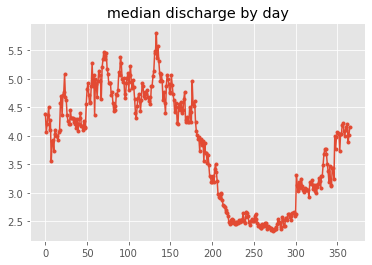

In [69]:
plt.plot(np.array(daily_stats["p50_va"]), ".-")
plt.title("median discharge by day")

Text(0.5, 1.0, 'mean discharge by day')

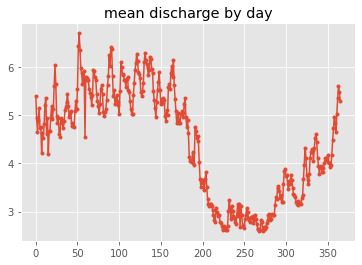

In [70]:
plt.plot(np.array(daily_stats["mean_va"]), ".-")
plt.title("mean discharge by day")

Text(0.5, 1.0, 'discharge by day')

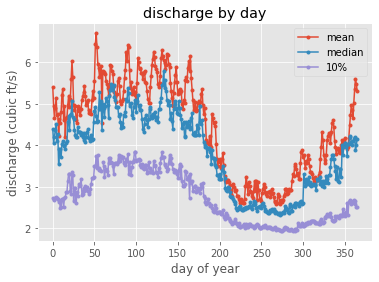

In [75]:
plt.plot(np.array(daily_stats["mean_va"]), ".-", label="mean")
plt.plot(np.array(daily_stats["p50_va"]), ".-", label="median")
# plt.plot(np.array(daily_stats["p90_va"]), ".-", label="90%")
plt.plot(np.array(daily_stats["p10_va"]), ".-", label="10%")
plt.xlabel("day of year")
plt.ylabel("discharge (cubic ft/s)")
plt.legend()
plt.title("discharge by day")

In [124]:
# can also get the monthly record, which uses a month AND year (i.e. does not run over the full record)
monthly_record = nwis.get_record(sites='03339000', service='stat', start='2017-12-31', parameterCd='00065', statReportType="monthly")
monthly_record

,agency_cd,site_no,parameter_cd,ts_id,loc_web_ds,year_nu,month_nu,mean_va,count_nu
0,USGS,03339000,00065,48112,NaN,1993,10,6.897,31
1,USGS,03339000,00065,48112,NaN,1993,11,6.450,30
2,USGS,03339000,00065,48112,NaN,1993,12,5.808,31
3,USGS,03339000,00065,48112,NaN,1994,2,4.422,28
4,USGS,03339000,00065,48112,NaN,1994,3,5.068,31
...,...,...,...,...,...,...,...,...,...
226,USGS,03339000,00065,48112,NaN,2022,9,2.351,30
227,USGS,03339000,00065,48112,NaN,2022,10,1.984,31
228,USGS,03339000,00065,48112,NaN,2022,11,2.292,30
229,USGS,03339000,00065,48112,NaN,2023,1,4.167,31


Text(0, 0.5, 'mean discharge (cubic ft/s)')

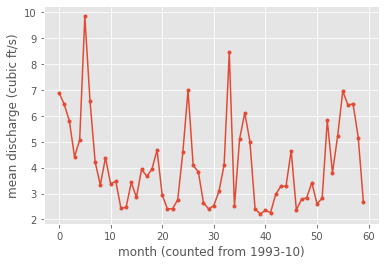

In [79]:
plt.plot(np.array(nwis.get_record(sites='03339000', service='stat', start='2017-12-31', parameterCd='00065', statReportType="monthly")["mean_va"])[:60], ".-")
plt.xlabel("month (counted from 1993-10)")
plt.ylabel("mean discharge (cubic ft/s)")

# Rasterization methods
Pull as much of this as possible from the NWM streamflow experiments in `pf_ml`!

## Get a DV discharge file for a training example

In [54]:
# load the geometries of the training examples
training_gdf = gpd.read_file("/home/nick/C2S-Python-API/notebooks/20230517_v2_v58_heldout_validation_set_geogroup_metrics.geojson")
# for each training geometry, check how many stream gauges it contains
contained = []
for geom in tqdm(training_gdf["geometry"].tolist()):
    contained.append(np.sum(dv_gauges.within(geom)))
training_gdf.loc[:, "num_gauges"] = contained

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1456/1456 [02:25<00:00, 10.01it/s]


In [55]:
training_gdf.iloc[0]

rmse_largediff_fbnf                                             0.338063
rmse_notn_fbnf                                                  0.169971
geometry               POLYGON ((-96.29352194405351 35.15411842539479...
num_gauges                                                            22
Name: 0, dtype: object

In [56]:
# use this geometry to query for the stream gauge IDs
bbox = training_gdf.iloc[0]["geometry"].bounds
daily_or_subdaily_values = "dv" 
discharge_or_height = "00060" # "00060": discharge, "00065": height

df_nwis, meta_nwis = nwis.what_sites(
    bBox=np.round(bbox, 6).tolist(), # truncate to avoid 400 error!
    outputDataTypeCd=daily_or_subdaily_values,
    parameterCd=discharge_or_height # discharge parameter
    )
df_nwis["years_of_history"] = df_nwis[['begin_date', 'end_date']].apply(lambda x: (pd.to_datetime(x['end_date']) - pd.to_datetime(x['begin_date'])).days / 365, axis=1)

print(f"Found {len(df_nwis):4} stream gauges. {df_nwis[df_nwis['years_of_history'] > 10].shape[0]:4} > 10 year history, "
      f"{df_nwis[df_nwis['years_of_history'] > 20].shape[0]:4} > 20 year history")

Found   23 stream gauges.   11 > 10 year history,    7 > 20 year history


In [57]:
bbox

(-96.29352194405351, 34.209756945451005, -95.065592721268, 35.15411842539479)

In [129]:
df_nwis

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,...,ts_id,loc_web_ds,medium_grp_cd,parm_grp_cd,srs_id,access_cd,begin_date,end_date,count_nu,years_of_history
0,USGS,07231500,"Canadian River at Calvin, OK",ST,34.977867,-96.243617,S,NAD83,683.16,0.13,...,111425,NaN,wat,NaN,1645423,0,1905-07-01,2023-08-16,30817,118.205479
1,USGS,07231965,"Ti Creek near Blanco, OK",ST,34.762598,-95.749987,U,NAD83,NaN,NaN,...,111426,NaN,wat,NaN,1645423,0,1980-07-01,1981-09-29,456,1.246575
2,USGS,07231975,"Brushy Creek near Haileyville, OK",ST,34.801487,-95.654707,U,NAD83,605.35,0.01,...,111427,NaN,wat,NaN,1645423,0,1978-07-01,1983-01-06,1606,4.520548
3,USGS,07231990,"Peaceable Creek near Haileyville, OK",ST,34.852042,-95.654429,F,NAD83,600.66,0.01,...,111428,NaN,wat,NaN,1645423,0,1978-07-01,1983-01-06,1651,4.520548
4,USGS,07232000,"Gaines Creek near Krebs, OK",ST,34.983430,-95.616930,U,NAD83,551.22,0.01,...,111429,NaN,wat,NaN,1645423,0,1942-10-01,1963-09-29,7669,21.008219
5,USGS,07232010,"Blue Creek near Blocker, OK",ST,35.040653,-95.572762,U,NAD83,NaN,NaN,...,295183,NaN,wat,NaN,1645423,0,1976-01-29,1983-01-06,2535,6.942466
6,USGS,07232024,"Deer Creek near McAlester, OK",ST,34.949540,-95.850272,U,NAD83,NaN,NaN,...,111431,NaN,wat,NaN,1645423,0,1978-10-01,1980-07-31,670,1.832877
7,USGS,07247450,"Fourche Maline near Wilburton, OK",ST,34.923710,-95.253025,U,NAD83,NaN,NaN,...,295189,NaN,wat,NaN,1645423,0,1978-07-01,1981-09-29,1187,3.249315
8,USGS,07247500,"Fourche Maline near Red Oak, OK",ST,34.912599,-95.155799,S,NAD83,540.99,0.09,...,111580,NaN,wat,NaN,1645423,0,1938-10-01,2023-08-16,30848,84.931507
9,USGS,07332900,"Coal Creek near Lehigh, OK",ST,34.451758,-96.232496,U,NAD83,572.53,0.01,...,111809,NaN,wat,NaN,1645423,0,1977-10-01,1981-09-29,1460,3.997260


/tmp/ipykernel_589038/1132026790.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_nwis.loc[:, "geometry"] = df_nwis.apply(lambda x: shapely.geometry.Point(x["dec_long_va"], x["dec_lat_va"]), axis=1)


<AxesSubplot:>

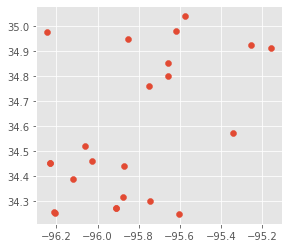

In [131]:
# add their geometries and turn into a geodataframe
df_nwis.loc[:, "geometry"] = df_nwis.apply(lambda x: shapely.geometry.Point(x["dec_long_va"], x["dec_lat_va"]), axis=1)

gdf = gpd.GeoDataFrame(df_nwis, crs=4326, geometry="geometry")
gdf.plot()

In [139]:
len(set(df_nwis["site_no"].tolist()))

21

In [223]:
# get the DV streamflow values for those gauges
site_ids = gdf["site_no"].tolist()
dv_gdf = nwis.get_dv(sites=site_ids, parameterCd="00060", start="2023-05-01", end="2023-05-01")
dv_gdf[0]

,,00060_Mean,00060_Mean_cd
site_no,datetime,,
07231500,2023-05-01 00:00:00+00:00,770.0,P
07247500,2023-05-01 00:00:00+00:00,89.6,A
07334000,2023-05-01 00:00:00+00:00,304.0,A
07334800,2023-05-01 00:00:00+00:00,229.0,A
07335790,2023-05-01 00:00:00+00:00,1350.0,A
07336200,2023-05-01 00:00:00+00:00,1610.0,A


In [224]:
dv_gdf = dv_gdf[0]
len(dv_gdf)

6

In [227]:
# add in their geometries
dv_gdf = dv_gdf.reset_index().merge(gdf[["site_no", "dec_lat_va", "dec_long_va"]], on="site_no", how="left")
dv_gdf

,site_no,datetime,00060_Mean,00060_Mean_cd,dec_lat_va,dec_long_va
0,07231500,2023-05-01 00:00:00+00:00,770.0,P,34.977867,-96.243617
1,07247500,2023-05-01 00:00:00+00:00,89.6,A,34.912599,-95.155799
2,07334000,2023-05-01 00:00:00+00:00,304.0,A,34.271485,-95.912205
3,07334000,2023-05-01 00:00:00+00:00,304.0,A,34.271485,-95.912205
4,07334800,2023-05-01 00:00:00+00:00,229.0,A,34.255090,-96.212768
5,07335790,2023-05-01 00:00:00+00:00,1350.0,A,34.574823,-95.340802
6,07336200,2023-05-01 00:00:00+00:00,1610.0,A,34.248712,-95.605248


In [58]:
# create the transform from the geometry
geom = training_gdf.iloc[0]["geometry"]
# assuming that we already know the dimensions, e.g. 350 x 350
transform = rasterio.transform.from_bounds(*geom.bounds, 350, 350)

## Method 1: no interpolation between points

In [274]:
def points_to_raster_no_interpolation(df, transform, var, width, height, lat_col="latitude", lon_col="longitude"):
    """Create a raster from lat/lon pairs in `df`. No interpolation between points is performed.
    When there are multiple lat/lon pairs at a single array index, the mean is used.
    Note that this returns an array and does not save anything to disk.

    Args:
        df (pd.DataFrame): dataframe with the columns [latitude, longitude, var] to be rasterized.
        transform (Affine): transform that defines the upperleft corner and resolution of the output raster.
        var (str): column in `df` containing the values to be rasterized.
        width (int): number of columns in output raster.
        height (int): number of rows in output raster.

    Returns:
        ndarray: rasterized version of `df` without any interpolation between points.
    """
    # make the empty grid to be filled
    vals_arr = np.zeros((height, width))

    # convert lat/lon points to convert to array indices
    df.loc[:, "arr_idxs"] = df.apply(
        lambda x: rasterio.transform.rowcol(transform, x[lon_col], x[lat_col]),
        axis=1,
    )
    # drop all points with negative indices AND all points with indices outside max rows/cols
    df = df.loc[df["arr_idxs"].apply(lambda x: (x[0] >= 0) & (x[1] >= 0)), :]
    df = df.loc[df["arr_idxs"].apply(lambda x: (x[0] < height) & (x[1] < width))]
    # count the number of values at a pixel location; could be more than one
    df.loc[:, "count"] = df.groupby("arr_idxs")["arr_idxs"].transform("count")
    # replace NaNs with 0 before taking mean
    df.loc[df[var].isna(), var] = 0
    # this is not taking the mean correctly! this just sets the value to the original value divided by the count; need to actually sum
    # get the rows with duplicate arr_idxs
    # return df
    duplicate_rows = df.duplicated("arr_idxs")
    df.loc[duplicated_rows, f"{var}_mean"] = df.loc[duplicated_rows, :].groupby("arr_idxs").transform("mean", numeric_only=True)[var]

    df.loc[df["count"] > 0, f"{var}_mean"] = df.loc[df["count"] > 0, var]
    # no longer need any rows with duplicate arr indices
    df = df.drop_duplicates(subset="arr_idxs")
    r, c = zip(*tuple(df.loc[:, "arr_idxs"]))
    vals_arr[r, c] = df.loc[:, f"{var}_mean"].values
    # return df
    return vals_arr

In [275]:
# totally arbitrary width and height, just for testing
vals_arr = points_to_raster_no_interpolation(dv_gdf, transform, "00060_Mean", 350, 350, "dec_lat_va", "dec_long_va")

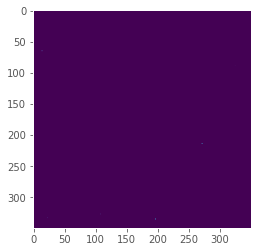

In [276]:
# the points are in there, they're just hard to see because they're so small!
fig, ax = plt.subplots(1,1)
ax.imshow(vals_arr)
ax.grid(False)
plt.show()

In [281]:
print(np.sum(vals_arr))

4352.6


## Method 1.5: Buffer points and rasterize the buffers
Use `rasterio.features.rasterize` to burn the buffered points into the raster

In [312]:
# assuming that we already know the dimensions, e.g. 350 x 350
transform = rasterio.transform.from_bounds(*geom.bounds, 350, 350)

In [ ]:
# make a gdf
gdf = df.copy()
gdf.loc[:, "geometry"] = df.apply(lambda x: shapely.geometry.Point(x["dec_long_va"], x["dec_lat_va"]), axis=1)
gdf = gpd.GeoDataFrame(gdf)
gdf.set_crs(4326, inplace=True)
gdf.set_geometry("geometry", inplace=True)

<AxesSubplot:>

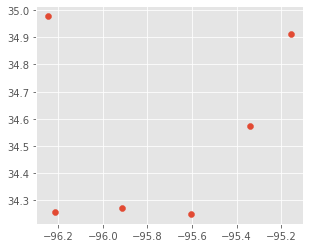

In [293]:
gdf.plot()

In [309]:
def buffered_points_to_raster(gdf, transform, var, width, height, buffer_dist=0.01):
    """Create a raster from lat/lon pairs in `df`. No interpolation between points is performed.
    When there are multiple lat/lon pairs at a single array index, the mean is used.
    Note that this returns an array and does not save anything to disk.

    Args:
        df (pd.DataFrame): dataframe with the columns [latitude, longitude, var] to be rasterized.
        transform (Affine): transform that defines the upperleft corner and resolution of the output raster.
        var (str): column in `df` containing the values to be rasterized.
        width (int): number of columns in output raster.
        height (int): number of rows in output raster.
        buffer_dist (float): distance in units of CRS to buffer from each point. Best to convert to a projected CRS before doing this.

    Returns:
        ndarray: rasterized version of `df` without any interpolation between points.
    """
    # make the empty grid to be filled
    vals_arr = np.zeros((height, width), dtype="float32")

    # buffer geometry of data
    gdf.geometry = gdf.buffer(buffer_dist)
    # create iterable of (geometry, value) pairs
    shapes = [(x.geometry, x[var]) for _, x in gdf.iterrows()]

    return rasterio.features.rasterize(shapes, out=vals_arr, transform=transform)

/tmp/ipykernel_589038/4035315255.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry = gdf.buffer(buffer_dist)


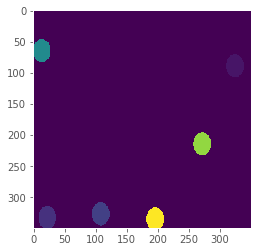

In [342]:
arr_out = buffered_points_to_raster(gdf, transform, "00060_Mean", 350, 350, 0.01)
plt.imshow(arr_out, interpolation="none")
plt.grid(False)

## Method 2: Naive interpolation
We could use gdal.Grid for this, which we know is reasonably performant and does the job. But it requires annoying data prep (e.g. saving a CSV to disk), lots of read/writes (e.g. VRT weirdness), and is not very extensible.

In [366]:
def naive_inteprolation(df, transform, var, width, height, lat_col, lon_col, interp_method="cubic"):
    vals_arr = points_to_raster_no_interpolation(df, transform, var, width, height, lat_col, lon_col)

    valid_points = vals_arr > 0
    values = vals_arr[valid_points]
    gridx, gridy = np.mgrid[:height, :width]
    
    # first arg is length 2 tuple: (x-indices, y-indices)
    outgrid = scipy.interpolate.griddata(valid_points.nonzero(), values, (gridx, gridy), method=interp_method)
    return outgrid

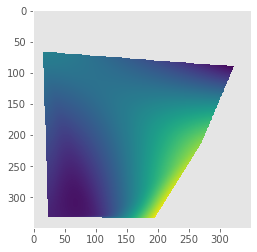

In [368]:
outgrid = naive_inteprolation(df, transform, "00060_Mean", 350, 350, "dec_lat_va", "dec_long_va")

plt.imshow(outgrid)
plt.grid(False)
plt.show()

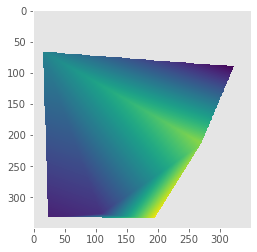

In [370]:
outgrid = naive_inteprolation(df, transform, "00060_Mean", 350, 350, "dec_lat_va", "dec_long_va", "linear")

plt.imshow(outgrid)
plt.grid(False)
plt.show()

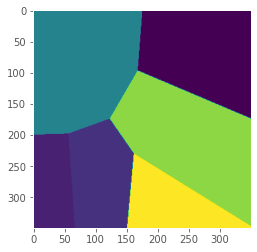

In [371]:
outgrid = naive_inteprolation(df, transform, "00060_Mean", 350, 350, "dec_lat_va", "dec_long_va", "nearest")

plt.imshow(outgrid)
plt.grid(False)
plt.show()

In [ ]:
# can we do this interpolation in a way that reaches the edges of the grid?
# extract the corners from the nearest interpolation?
# or else use a larger area of stream gauges, create interpolated surface for that larger area, then clip down to the AOI... 
# ... lots of steps, but much more physically meaningful

# could also use the nearest interpolation to try to get out to the edges, but then add the attenuation factor to compensate, i.e. go to zero far from gauges

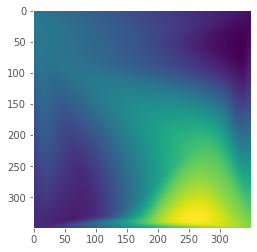

In [341]:
vals_arr = points_to_raster_no_interpolation(df, transform, "00060_Mean", 350, 350, "dec_lat_va", "dec_long_va")

valid_points = vals_arr > 0
values = vals_arr[valid_points]
gridx, gridy = np.mgrid[:350, :350]

# first arg is length 2 tuple: (x-indices, y-indices)
nearest_interp = scipy.interpolate.griddata(valid_points.nonzero(), values, (gridx, gridy), method="nearest")

# use the nearest interpolation to update the corners
vals_arr[0, 0] = nearest_interp[0, 0]
vals_arr[-1, 0] = nearest_interp[-1, 0]
vals_arr[0, -1] = nearest_interp[0, -1]
vals_arr[-1, -1] = nearest_interp[-1, -1]

valid_points = vals_arr > 0
values = vals_arr[valid_points]
gridx, gridy = np.mgrid[:350, :350]

outgrid = scipy.interpolate.griddata(valid_points.nonzero(), values, (gridx, gridy), method="cubic")


plt.imshow(outgrid)
plt.grid(False)
plt.show()

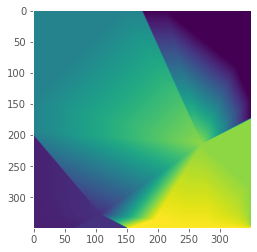

In [344]:
vals_arr = points_to_raster_no_interpolation(df, transform, "00060_Mean", 350, 350, "dec_lat_va", "dec_long_va")

valid_points = vals_arr > 0
values = vals_arr[valid_points]
gridx, gridy = np.mgrid[:350, :350]

# first arg is length 2 tuple: (x-indices, y-indices)
nearest_interp = scipy.interpolate.griddata(valid_points.nonzero(), values, (gridx, gridy), method="nearest")

# use the nearest interpolation to update the corners
vals_arr[:, 0] = nearest_interp[:, 0]  # first col
vals_arr[:, -1] = nearest_interp[:, -1]  # last col
vals_arr[0, :] = nearest_interp[0, :]  # first row
vals_arr[-1, :] = nearest_interp[-1, :]  # last row

valid_points = vals_arr > 0
values = vals_arr[valid_points]
gridx, gridy = np.mgrid[:350, :350]

outgrid = scipy.interpolate.griddata(valid_points.nonzero(), values, (gridx, gridy), method="linear")


plt.imshow(outgrid)
plt.grid(False)
plt.show()

## Method 2.5
As above, but attenuate the interpolation based on the inverse distance from a measurement

In [405]:
def distance_matrix(x0, y0, x1, y1):
    """
    Compute pairwise 2D Euclidean distance between two sets of points.
    
    Args:
        x0 (list, array): x-coordinates for points 0
        y0 (list, array): y-coordinates for points 0
        x1 (list, array): x-coordinates for points 1
        y1 (list, array): y-coordiantes for points 1

    Returns:
        
    """
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)
    

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # if the distance is zero, set to 1.0 so that the weight doesn't go to infinity
    dist[dist == 0] = 1.0
    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # return weights
    # Make weights sum to one
    # weights /= weights.sum(axis=0)

    # # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi



In [408]:
# need to convert to x-y coords to array indices (have code for this in the no-interpolation method)
# convert lat/lon points to convert to array indices
lon_col = "dec_long_va"
lat_col = "dec_lat_va"
df.loc[:, "arr_idxs"] = df.apply(
    lambda x: rasterio.transform.rowcol(transform, x[lon_col], x[lat_col]),
    axis=1,
)

y = [point[0] for point in df["arr_idxs"].tolist()]
x = [point[1] for point in df["arr_idxs"].tolist()]

z = np.ones_like(x)  # just set the "weights" to 1 since we just want to know where the points are, not the gauge values

# create meshgrid of the AOI
width, height = 350, 350
xi, yi = np.arange(0, width), np.arange(0, height)
xi, yi = np.meshgrid(xi, yi)  # indices to at which to calculate inverse distance
xi, yi = xi.flatten(), yi.flatten()

idw = simple_idw(x, y, z, xi, yi)
idw = idw.reshape((width, height))

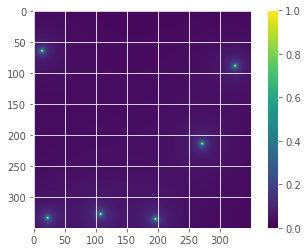

In [412]:
plt.imshow(idw, vmin=0, vmax=1)
plt.colorbar()

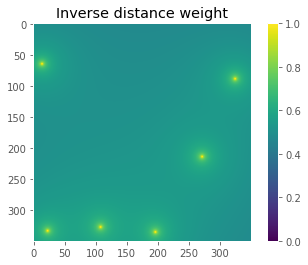

In [424]:
# we can make this drop off a little bit slower if we want
plt.imshow(idw ** 0.2, vmin=0, vmax=1)
plt.grid(False)
plt.title("Inverse distance weight")
plt.colorbar()

### Replacing corners only with nearest values before cubic interpolation

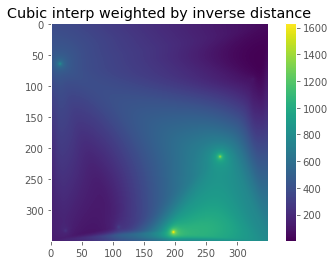

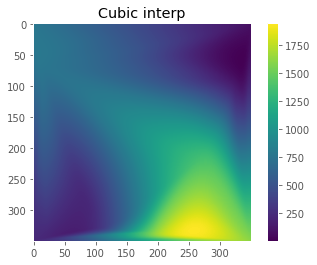

In [421]:
# multiply this by one of the interpolated results
width, height = 350, 350
nearest_interp = naive_inteprolation(df, transform, "00060_Mean", width, height, "dec_lat_va", "dec_long_va", "nearest")

# use the nearest interpolation to update the corners
vals_arr = points_to_raster_no_interpolation(df, transform, "00060_Mean", 350, 350, "dec_lat_va", "dec_long_va")
vals_arr[0, 0] = nearest_interp[0, 0]
vals_arr[-1, 0] = nearest_interp[-1, 0]
vals_arr[0, -1] = nearest_interp[0, -1]
vals_arr[-1, -1] = nearest_interp[-1, -1]

valid_points = vals_arr > 0
values = vals_arr[valid_points]
gridx, gridy = np.mgrid[:width, :height]

outgrid = scipy.interpolate.griddata(valid_points.nonzero(), values, (gridx, gridy), method="cubic")


weighted_interp = idw ** 0.2 * outgrid

plt.title("Cubic interp weighted by inverse distance")
plt.imshow(weighted_interp)
plt.grid(False)
plt.colorbar()
plt.show()

plt.title("Cubic interp")
plt.imshow(outgrid)
plt.grid(False)
plt.colorbar()
plt.show()

### Replacing full edges with nearest values before cubic interpolation

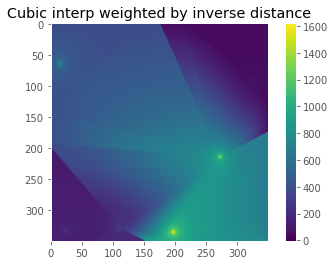

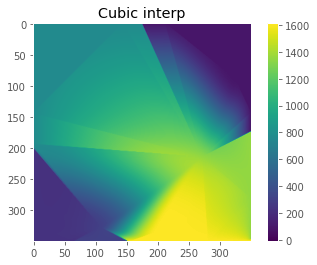

In [422]:
# multiply this by one of the interpolated results
width, height = 350, 350
nearest_interp = naive_inteprolation(df, transform, "00060_Mean", width, height, "dec_lat_va", "dec_long_va", "nearest")

# use the nearest interpolation to update the corners
vals_arr = points_to_raster_no_interpolation(df, transform, "00060_Mean", 350, 350, "dec_lat_va", "dec_long_va")
vals_arr[:, 0] = nearest_interp[:, 0]  # first col
vals_arr[:, -1] = nearest_interp[:, -1]  # last col
vals_arr[0, :] = nearest_interp[0, :]  # first row
vals_arr[-1, :] = nearest_interp[-1, :]  # last row

valid_points = vals_arr > 0
values = vals_arr[valid_points]
gridx, gridy = np.mgrid[:width, :height]

outgrid = scipy.interpolate.griddata(valid_points.nonzero(), values, (gridx, gridy), method="cubic")


weighted_interp = idw ** 0.2 * outgrid

plt.title("Cubic interp weighted by inverse distance")
plt.imshow(weighted_interp)
plt.grid(False)
plt.colorbar()
plt.show()

plt.title("Cubic interp")
plt.imshow(outgrid)
plt.grid(False)
plt.colorbar()
plt.show()

## Method 3
Clip the interpolated result so that it only exists near streams.
1. Run an interpolation method on the streamflow data and save as a GeoTIFF.
2. Create a raster of the streams in the AOI (e.g. buffer then burn in)
3. Multiply the binary stream raster by the interpolated stream gauge raster.

## Method 4
1. Run an interpolation method on the streamflow data and save as a GeoTIFF.
2. Get a HAND raster matching the extent and resolution of the streamflow raster.
3. Calculate cumulative cost distance from each gauge, using HAND as the cost surface.
    - Might need to run a separate calculation for each gauge, such that there is an array of cumulative HAND values for each gauge
    - Then, we would using the minimum cumulative sum for each pixel to create the weighting raster.
    - E.g. if there are 6 gauges in an example, we would create 6 cumulative HAND rasters, then take the minimum across those rasters to get cumulative HAND from nearest gauge.
  

<b>It would be really nice to create a ChippingUtils subclass for HAND...</b>

WhiteboxTools has a function that basically does what we're looking for here! `CostDistance`

### Save interpolated streamflow as a GeoTIFF
This is required for whitebox cost distance surface calculation

In [465]:
rasterio.warp.calculate_default_transform("EPSG:4269", "EPSG:4269", 350, 350, *geom.bounds, res=0.005)

(Affine(0.0031296011227697645, 0.0, -96.29352194405351,
        0.0, -0.0031296011227697645, 35.15411842539479),
 392,
 302)

In [466]:
# using the same geom that we've been using for previous experiments
geom = training_gdf.iloc[0]["geometry"]
# assuming that we already know the approx dimensions, e.g. 350 x 350
# get a better transform so that the resolution is isotropic
transform, w, h = rasterio.warp.calculate_default_transform("EPSG:4269", "EPSG:4269", 350, 350, *geom.bounds, res=0.005)

In [467]:
# use this geometry to query for the stream gauge IDs
bbox = geom.bounds
daily_or_subdaily_values = "dv" 
discharge_or_height = "00060" # "00060": discharge, "00065": height

df_nwis, meta_nwis = nwis.what_sites(
    bBox=np.round(bbox, 6).tolist(), # truncate to avoid 400 error!
    outputDataTypeCd=daily_or_subdaily_values,
    parameterCd=discharge_or_height # discharge parameter
    )

# add their geometries and turn into a geodataframe
df_nwis.loc[:, "geometry"] = df_nwis.apply(lambda x: shapely.geometry.Point(x["dec_long_va"], x["dec_lat_va"]), axis=1)
gdf = gpd.GeoDataFrame(df_nwis, crs=4326, geometry="geometry")

# get the DV streamflow values for those gauges
site_ids = gdf["site_no"].tolist()
dv_gdf = nwis.get_dv(sites=site_ids, parameterCd="00060", start="2023-05-01", end="2023-05-01")
dv_gdf = dv_gdf[0]
df = dv_gdf.reset_index().merge(gdf[["site_no", "dec_lat_va", "dec_long_va"]], on="site_no", how="left")
df

,site_no,datetime,00060_Mean,00060_Mean_cd,dec_lat_va,dec_long_va
0,07231500,2023-05-01 00:00:00+00:00,770.0,P,34.977867,-96.243617
1,07247500,2023-05-01 00:00:00+00:00,89.6,A,34.912599,-95.155799
2,07334000,2023-05-01 00:00:00+00:00,304.0,A,34.271485,-95.912205
3,07334000,2023-05-01 00:00:00+00:00,304.0,A,34.271485,-95.912205
4,07334800,2023-05-01 00:00:00+00:00,229.0,A,34.255090,-96.212768
5,07335790,2023-05-01 00:00:00+00:00,1350.0,A,34.574823,-95.340802
6,07336200,2023-05-01 00:00:00+00:00,1610.0,A,34.248712,-95.605248


In [472]:
# get the interpolated surface (using the cubic interp with updated corners)
nearest_interp = naive_inteprolation(df, transform, "00060_Mean", w, h, "dec_lat_va", "dec_long_va", "nearest")

# use the nearest interpolation to update the corners
vals_arr = points_to_raster_no_interpolation(df, transform, "00060_Mean", w, h, "dec_lat_va", "dec_long_va")
vals_arr[0, 0] = nearest_interp[0, 0]
vals_arr[-1, 0] = nearest_interp[-1, 0]
vals_arr[0, -1] = nearest_interp[0, -1]
vals_arr[-1, -1] = nearest_interp[-1, -1]

valid_points = vals_arr > 0
values = vals_arr[valid_points]
gridx, gridy = np.mgrid[:h, :w]

# interpolate using cubic with the updated corners
outgrid = scipy.interpolate.griddata(valid_points.nonzero(), values, (gridx, gridy), method="cubic")

In [473]:
# save it to geotiff
base_profile = cog_profiles["deflate"]
profile = base_profile.copy()
profile["transform"] = transform
profile["width"] = w
profile["height"] = h
profile["count"] = 1
profile["crs"] = 4269
profile["dtype"] = "float32"

with rasterio.open("./test_data/streamgauge_interp.tif", "w", **profile) as dst:
    dst.write_band(1, outgrid)

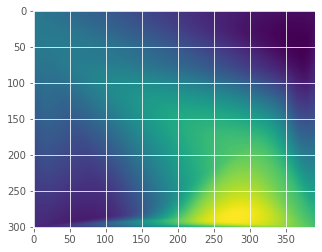

In [474]:
with rasterio.open("./test_data/streamgauge_interp.tif", "r") as src:
    arr = src.read(1)
plt.imshow(arr)

### Save GeoTIFF just of the streamflow locations
This is what is needed for the whitebox costdistance function

In [494]:
no_interp = points_to_raster_no_interpolation(df, transform, "00060_Mean", w, h, "dec_lat_va", "dec_long_va")

# save it to geotiff
base_profile = cog_profiles["deflate"]
profile = base_profile.copy()
profile["transform"] = transform
profile["width"] = w
profile["height"] = h
profile["count"] = 1
profile["crs"] = 4269
profile["dtype"] = "float32"

with rasterio.open("./test_data/streamgauge_no_interp.tif", "w", **profile) as dst:
    dst.write_band(1, no_interp)

### Download and processing a matching HAND raster

In [24]:
def reproject_polygon(source_poly, in_crs, out_crs):
    """This method reproject a give bounding box in a specific EPSG code to another EPSG code.
    Args:
        source_poly (Polygon): Polygon from source dataset.
        in_crs (str): The EPSG code for the input CRS.
        out_crs (str): The EPSG code for the desired CRS.
    Returns:
        Polygon: Reprojected Polygon into new CRS.
    """
    in_proj = Proj(in_crs)
    out_proj = Proj(out_crs)
    project = Transformer.from_proj(in_proj, out_proj, always_xy=True)
    poly_dest = shapely.ops.transform(project.transform, source_poly)

    return poly_dest

In [25]:
# start with the 250m projected HAND 
hand_mosaic_path = "/data/static/hand/mosaic_250m_avg.tif"
# convert the bounds of the streamflow raster into this CRS so we can do a windowed read
with rasterio.open(hand_mosaic_path, "r") as src:
    hand_profile = src.profile
with rasterio.open("/home/nick/C2S-Python-API/notebooks/test_data/streamgauge_interp.tif", "r") as src:
    stream_profile = src.profile
    stream_bounds = src.bounds
stream_bounds_reproj = reproject_polygon(shapely.geometry.box(*stream_bounds), stream_profile["crs"], hand_profile["crs"]).bounds

In [26]:
# read that window from the HAND mosaic and save it as a geotiff
window = rasterio.windows.from_bounds(
    *stream_bounds_reproj, 
    transform=hand_profile["transform"],
)

with rasterio.open(hand_mosaic_path, "r") as src:
    hand_arr = src.read(1, window=window)

In [490]:
# for now, let's just infill the NaN values with 0. Can do something smarter later
hand_arr[hand_arr < 0] = 0

In [491]:
# save the HAND array to a raster that matches the streamflow raster
with rasterio.open("./test_data/hand_window_example.tif", "w", **stream_profile) as dst:
    dst.write_band(1, hand_arr)

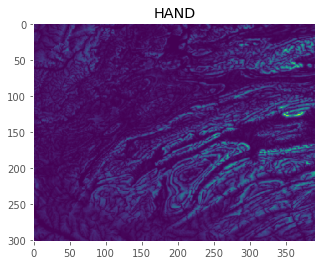

In [29]:
with rasterio.open("/home/nick/C2S-Python-API/notebooks/test_data/hand_window_example.tif") as src:
    hand_arr = src.read(1)
plt.title("HAND")
plt.imshow(np.ma.masked_less(hand_arr, 0))
plt.grid(False)
plt.show()

### Calculate a cost surface
Calculating the accumulated cost (i.e. sum of HAND) from each stream gauge

In [5]:
# this assumes that WBT is inside the c2s directory
from c2s.WBT.whitebox_tools import WhiteboxTools
wbt = WhiteboxTools()

In [12]:
wbt.set_whitebox_dir('/home/nick/C2S-Python-API/c2s/WBT/')

In [15]:
wbt.work_dir = "/home/nick/C2S-Python-API/notebooks/"

In [17]:
wbt.cost_distance(
    "/home/nick/C2S-Python-API/notebooks/test_data/streamgauge_no_interp.tif",
    "/home/nick/C2S-Python-API/notebooks/test_data/hand_window_example.tif",
    "/home/nick/C2S-Python-API/notebooks/test_data/output_costdistance.tif",
    "/home/nick/C2S-Python-API/notebooks/test_data/output_backlink.tif",
)

./whitebox_tools --run="CostDistance" --wd="/home/nick/C2S-Python-API/notebooks/" --source='/home/nick/C2S-Python-API/notebooks/test_data/streamgauge_no_interp.tif' --cost='/home/nick/C2S-Python-API/notebooks/test_data/hand_window_example.tif' --out_accum='/home/nick/C2S-Python-API/notebooks/test_data/output_costdistance.tif' --out_backlink='/home/nick/C2S-Python-API/notebooks/test_data/output_backlink.tif' -v --compress_rasters=False

****************************
* Welcome to CostDistance  *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading source data...
Reading cost data...
Initializing: 0%
Initializing: 1%
Initializing: 2%
Initializing: 3%
Initializing: 4%
Initializing: 5%
Initializing: 6%
Initializing: 7%
Initializing: 8%
Initializing: 9%
Initializing: 10%
Initializing: 11%
Initializing: 12%
Initializing: 13%
Initializing: 14%
Initializing: 15%
Initializing: 16%
Initializing: 17%
Initializing: 18%
Initializing: 19%
Initializing: 20%
Ini

0

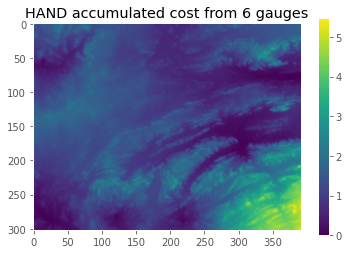

In [45]:
cost_surface_path = "/home/nick/C2S-Python-API/notebooks/test_data/output_costdistance.tif"
with rasterio.open(cost_surface_path, "r") as src:
    cost_arr = src.read(1)

plt.imshow(cost_arr)
plt.grid(False)
plt.title("HAND accumulated cost from 6 gauges")
plt.colorbar()
plt.show()

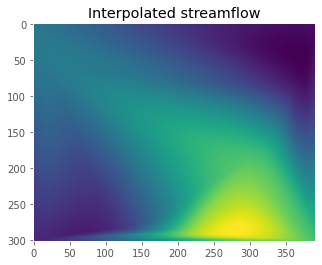

In [32]:
# check the interpolated streamflow array
with rasterio.open("/home/nick/C2S-Python-API/notebooks/test_data/streamgauge_interp.tif", "r") as src:
    streamflow_arr = src.read(1)
    
plt.imshow(streamflow_arr)
plt.grid(False)
plt.title("Interpolated streamflow")
plt.show()

### Use cost surface to weight the interpolated raster
Lower values in the cost surface = physically closer to gauges. So we want something like the inverse of the cost surface

In [30]:
np.min(cost_arr)

0.0

In [31]:
np.mean(cost_arr)

1.299871

/tmp/ipykernel_685510/2147873875.py:3: RuntimeWarning: divide by zero encountered in true_divide
  weighted_arr = np.where(cost_arr != 0, streamflow_arr / cost_arr, streamflow_arr)


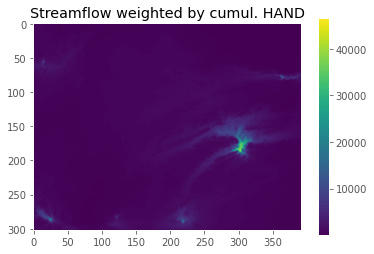

In [46]:
# where the cost_arr is 0, we are right on top of a gauge; just use the gauge's original value
weighted_arr = np.zeros_like(cost_arr)
weighted_arr = np.where(cost_arr != 0, streamflow_arr / cost_arr, streamflow_arr)

plt.imshow(weighted_arr)
plt.grid(False)
plt.title("Streamflow weighted by cumul. HAND")
plt.colorbar()
plt.show()

In [43]:
np.sum(np.isnan(weighted_arr))

0